<a href="https://colab.research.google.com/github/sjdonado/covid19-spread-forecast/blob/master/sir_covid_forecasting_colombia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COVID-19 Spread Forecasting

This is a research project with the purpose of building a model to make forecasts of the COVID-19 in Colombia.

Students:
- Oskhar Arrieta
- Juan Estrada
- Sharon Figueroa
- Brian Ramirez
- Juan Rodriguez
- Cristian Yepes

*Universidad del Norte, 2020*

# Setup

In [0]:
# Import general libs
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
DRIVE_ROOT_PATH = '/content/drive/Shared drives/data-mining/'

# Data preparation

## Load dataset

In [0]:
# Read local data
import pandas as pd
dataset = pd.read_csv(f'{DRIVE_ROOT_PATH}dataset/Casos_positivos_de_COVID-19_en_Colombia.csv',
                      sep=',',
                      infer_datetime_format=True
                     )

# Use custom columns name
dataset.columns = [
                    'id_case', 
                    'notification_date',
                    'code', 
                    'city',
                    'department',
                    'current_status',
                    'age',
                    'sex',
                    'type',
                    'status',
                    'country_origin',
                    'fis',
                    'death_date',
                    'diagnosis_date',
                    'recover_date',
                    'web_report_date',
                    'recover_type'
                  ]

## Preprocess dataset

In [0]:
# Lowercase the current_status column. Some labels have capital letter
dataset.current_status = dataset.current_status.str.casefold()

# Merge categories into 3 (Recovered, Confirmed, Dead)
dataset.loc[
            dataset.current_status.isin(['recuperado', 'recuperado (hospital)']), 
            'current_status'
           ] = 'recovered'

dataset.loc[
            dataset.current_status.isin(['casa', 'hospital', 'hospital uci']), 
            'current_status'
           ] = 'confirmed'

dataset.loc[dataset.current_status == 'fallecido', 'current_status'] = 'dead'

# Parse dates columns into Datetime
dataset.diagnosis_date = pd.to_datetime(dataset.loc[dataset.diagnosis_date != 'SIN DATO', 'diagnosis_date'])
dataset.death_date = pd.to_datetime(dataset.loc[dataset.death_date != 'SIN DATO', 'death_date'])
dataset.recover_date = pd.to_datetime(dataset.loc[dataset.recover_date != 'SIN DATO', 'recover_date'])

## Generate time series from the current data

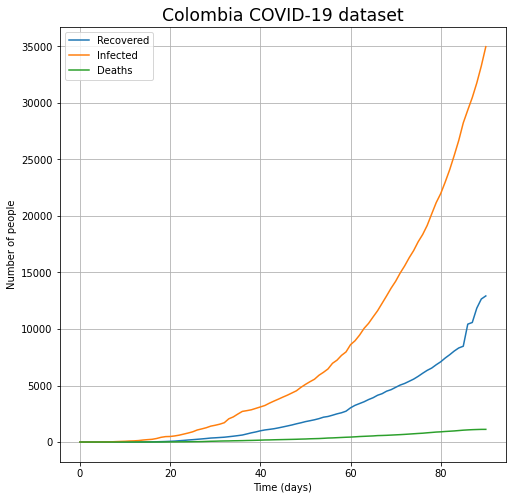

In [10]:
# Split data into arrays which represent all the possible statuses
diagnosis_dates = dataset.loc[dataset.diagnosis_date.notna(), 'diagnosis_date']
death_dates = dataset.loc[dataset.death_date.notna(), 'death_date']
recovered_dates = dataset.loc[dataset.recover_date.notna(), 'recover_date']

# Get minimum and maximun date in order to build the time range
first_date = dataset.diagnosis_date[0]
last_date = max([*diagnosis_dates, *death_dates, *recovered_dates])

total_days = (last_date - first_date).days
Recovered = []
Confirmed = []
Deaths = []

# Create the time range
Time = pd.date_range(start=first_date, end=last_date).tolist()

# Loop through the  defined time range
for date in Time:
  Recovered.append((date == recovered_dates).sum())
  Confirmed.append((date == diagnosis_dates).sum())
  Deaths.append((date == death_dates).sum())

# Plot the time series
import matplotlib.pyplot as plt
range_days = list(range(0, total_days + 1))
plt.figure(figsize=(8, 8))
plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
plt.plot(range_days, np.cumsum(Recovered), label='Recovered')
plt.plot(range_days, np.cumsum(Confirmed), label='Infected')
plt.plot(range_days, np.cumsum(Deaths), label='Deaths')
plt.xlabel('Time (days)')
plt.ylabel('Number of people')
plt.legend()
plt.grid()
plt.title('Colombia COVID-19 dataset')
plt.show()

# SIR Model fiting

## Define model parameters

In [0]:
# Colombia population according to DANE (2018)
colombia_population = 48258494 

# Average virus duration in a host
avg_virus_duration = 14

# Recovery rate
gamma = 1 / avg_virus_duration

# Basic reproduction number - According to official articles, 2 <= R0 <= 3
R0 = 3

# Infection rate (interaction rate * Probability of infection)
beta = gamma * R0

## Define the model function

In [0]:
def SIR(y, t, N, beta, gamma):
  S, I, R = y
  dS = -beta * S * I / N
  dI = beta * S * I / N - gamma * I
  dR = gamma * I
  return dS, dI, dR

# Results

## Solve SIR equations system

In [0]:
# Define range time to forecast with SIR
T = list(range(0, 360))

# Define the initial conditions
I0, R0, D0 = Confirmed[0], Recovered[0], Deaths[0]
initial_condition = colombia_population - I0 + R0 + D0, I0, R0

# Solve the ODE
from scipy.integrate import odeint
ret = odeint(SIR, initial_condition, range_days, args=(colombia_population, beta, gamma))
S, I, R = ret.T

## Plot SIR solution

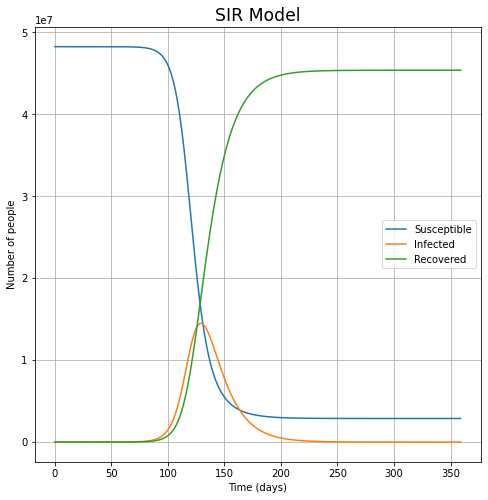

In [68]:
plt.figure(figsize=(8, 8))
plt.rcParams.update({'axes.titlesize': 'xx-large'}) 
plt.plot(range_days, S, label='Susceptible')
plt.plot(range_days, I, label='Infected')
plt.plot(range_days, R, label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Number of people')
plt.legend()
plt.grid()
plt.title('SIR Model')
plt.show()

# References

- https://www.ucm.es/icei/file/iceipapercovid12
- http://www.scielo.org.co/pdf/rsap/v22n1/0124-0064-rsap-22-01-e185977.pdf
- http://revistaendocrino.org/index.php/rcedm/article/view/572/755